# Standarize Rasters
<!-- ## Responsabilities of this file
* Create masks of brazilian territoy
* Create empty masks
* Standarize all rasters on empty maks Affines -->


## Who is Running?

In [ ]:
#Matheus
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

##General Parameters

In [ ]:
# Reference Data Paths
ref_image_path = project_root + "/Data/Rasters/Envirem_Rasters/envir11_PET_coldest_quarter.tif"
shapefiles_folder = project_root + "/Data/Shapefiles/Shapefiles_Brasil" 
rasters_root_folders_list =  [project_root+"/Data/Rasters/Elevation_Rasters", project_root+"/Data/Rasters/Bioclim_Rasters",project_root+"/Data/Rasters/Envirem_Rasters"]

# Output File Names
territory_mask_name = "brazilian_mask_standarized.tif"
empty_mask_name = "empty_mask_standarized.tif" 
base_txt_files_path = project_root + "/Data/Standarized_Rasters/TXT_Aux_Files" #
base_csv_files_path = project_root + "/Data/Standarized_Rasters/CSV_Aux_Files"
base_rasters_folder_path = project_root + "/Data/Standarized_Rasters/Base_Rasters"
standarized_rasters_root_folders_list =  [project_root+"/Data/Standarized_Rasters/Elevation_Rasters", project_root+"/Data/Standarized_Rasters/Bioclim_Rasters",project_root+"/Data/Standarized_Rasters/Envirem_Rasters"] 

# Brazil Limits
country_limits = (-73.981934,-34.792929, -33.750035, 5.271478)


## Instalações

In [ ]:
! pip install geopandas --quiet
! pip install rasterio --quiet
! pip install earthpy --quiet

##  Retrieving aux Classes

In [ ]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py

--2020-12-13 15:22:58--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     800  --.-KB/s    in 0s      

2020-12-13 15:22:58 (20.6 MB/s) - ‘utils.py.1’ saved [800/800]



In [ ]:
from utils import Utils
utils_methods = Utils()

## Shapefiles

In [ ]:
import os
shapefile_brasi_pais_folder = shapefiles_folder + '/Pais'
brasil_pais_shp = os.path.join(shapefile_brasi_pais_folder, 'BRA_adm0.shp')

## Create if necessary Standarized Data Folders

In [ ]:
for standarized_raster_folder_path in standarized_rasters_root_folders_list:
  utils_methods.create_folder_structure(standarized_raster_folder_path)
utils_methods.create_folder_structure(base_txt_files_path)
utils_methods.create_folder_structure(base_csv_files_path)
utils_methods.create_folder_structure(base_rasters_folder_path)

## Creating some auxiliary functions

Convert dtype to numpy32

In [ ]:
import numpy as np
def convert_dtype_to_float32(image_path:str):
  src=rasterio.open(image_path)
  band=src.read(1)
  new_band = band.copy().astype(np.float32)
  profile = src.profile
  profile['dtype'] = np.float32
  with rasterio.open(image_path, 'w', **profile) as dst:
      dst.write(new_band.astype(rasterio.float32), 1)

Set all no data  Values to -9999

In [ ]:
#pode ser chamado apenas para pequenos raster
def set_nodata_to_value(image_path:str,no_data_val):
  src=rasterio.open(image_path)
  band=src.read(1)
  new_band = band.copy()
  profile = src.profile
  if profile['nodata'] <= no_data_val:
    new_band = np.where(new_band <  no_data_val ,no_data_val, new_band)
    profile['nodata'] = no_data_val
  else:
    raise Exception("Manually verify this raster. There is sometihng strange with no data val")
  
  with rasterio.open(image_path, 'w', **profile) as dst:
      dst.write(new_band, 1)

Burn shapefile mask on raster

In [ ]:
# A script to rasterise a shapefile to the same projection & pixel resolution as a reference image.
from osgeo import ogr, gdal
import subprocess
import shutil

def create_base_raster(burnVal:int,ref_image_path:str,output_image_name:str,shapefile_vector_path=None):
    InputVector = shapefile_vector_path

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(ref_image_path, gdal.GA_ReadOnly)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterise
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(output_image_name, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+output_image_name+" 2 4 8 16 32 64", shell=True)
    print("Done.")

Create empty raster

In [ ]:
def create_empty_raster(ref_image_path:str,output_image_path_name:str):
  src = rasterio.open(ref_image_path)
  band= src.read(1,masked=True)
  new_band = band.copy()
  new_band.fill(0)
  profile = src.profile
  
  with rasterio.open(output_image_path_name, 'w', **profile) as dst:
          dst.write(new_band, 1)

## Creating Masks

Creating Brazilian Mask

Rasterising shapefile...
Done.


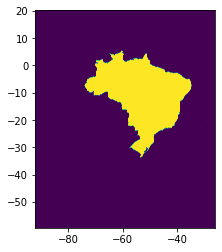

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 9549,
 'nodata': 0.0,
 'transform': Affine(0.00833333333333334, 0.0, -92.0166666666667,
       0.0, -0.008333333333333333, 20.0916666666667),
 'width': 7894}

In [ ]:
import rasterio
from rasterio.plot import show

create_base_raster(burnVal=255,
                   ref_image_path = ref_image_path,
                   output_image_name = territory_mask_name,
                   shapefile_vector_path=brasil_pais_shp)

territory_mask_path = os.path.join(base_rasters_folder_path,territory_mask_name)
shutil.copy("/content/"+territory_mask_name, territory_mask_path)
convert_dtype_to_float32(territory_mask_path)

brazilian_mask_raster = rasterio.open(territory_mask_path)
show((brazilian_mask_raster, 1))
brazilian_mask_raster.meta

Creating Empty Mask

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 7894, 'height': 9549, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333333333334, 0.0, -92.0166666666667,
       0.0, -0.008333333333333333, 20.0916666666667), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


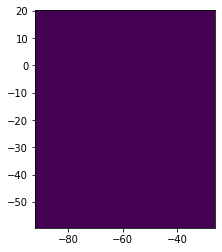

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 9549,
 'nodata': -9999.0,
 'transform': Affine(0.00833333333333334, 0.0, -92.0166666666667,
       0.0, -0.008333333333333333, 20.0916666666667),
 'width': 7894}

In [ ]:
empty_mask_path = os.path.join(base_rasters_folder_path,empty_mask_name)
create_empty_raster(ref_image_path = ref_image_path,output_image_path_name =empty_mask_path)
convert_dtype_to_float32(empty_mask_path)
empty_mask_raster = rasterio.open(empty_mask_path)
show((empty_mask_raster, 1))
empty_mask_raster.meta
          

In [ ]:
empty_mask_raster.read(1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Converting all Enverionment Rasters to Standard Configurations

Original rasters list and names

In [ ]:
list_raster_files=[]
list_names_raster=[]

for raster_root_folder in rasters_root_folders_list:
  for root, dirs, files in os.walk(raster_root_folder):
      for file in files:
          if file.endswith('.tif') and "stacked" not in file:
              list_raster_files.append(raster_root_folder+"/"+file)
              name=file.replace(".tif","")
              list_names_raster.append(name)
print(list_raster_files)
print(list_names_raster)

['/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Elevation_Rasters/elev3_envirem_topographic_wetness_index.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Elevation_Rasters/elev2_envirem_terrain_roughness_index.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Elevation_Rasters/elev1_strm_worldclim_elevation.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Bioclim_Rasters/bio1_annual_mean_temperature.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Bioclim_Rasters/bio2_mean_diurnal_range.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Bioclim_Rasters/bio3_isothermality.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Bioclim_Rasters/bio4_temperature_seasonality.tif', '/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Data/Rasters/Bioclim_Rasters/bio5_max_temperature_of_warmest_month.tif', '/content/drive/MyDrive/M

Functions to reescale and crop raster based on the base raster

In [ ]:
#Import gdal
from osgeo import gdal
import gdal, ogr, os, osr
import rasterio
from rasterio.enums import Resampling


def get_window_from_extent(ref_raster,objective_raster):
  """ Get a portion form a raster array based on the country limits"""
  #Reference Raster
  ref_aff = ref_raster.meta['transform']
  ref_width = ref_raster.profile['width']
  ref_heigh = ref_raster.profile['height']
  #Objective Raster
  obj_aff = objective_raster.meta['transform']
  obj_width = objective_raster.profile['width']
  obj_heigh = objective_raster.profile['height']
  # X limits
  x_min_limit = ref_aff[2]
  x_max_limit = x_min_limit + ref_aff[0]*ref_width
  # Y limits
  y_max_limit = ref_aff[5]
  y_min_limit = y_max_limit + ref_aff[4]*ref_heigh


  col_start, row_start = ~obj_aff * (x_min_limit, y_max_limit)
  col_stop, row_stop = ~obj_aff * (x_max_limit, y_min_limit)
  return ((round(row_start,0),round(row_stop,0)), (round(col_start,0),round(col_stop,0)))


def reescale_and_crop_to_reference(ref_file_path,objective_file_path,output_file_path):
    """ Reescale a raster array on the desired resolution """

    ref_raster = rasterio.open(ref_file_path)
    ref_raster_array = ref_raster.read(1).copy()
    objective_raster =  rasterio.open(objective_file_path)

    
    # Same Resolutions and Same Size
    if ref_raster.shape == objective_raster.shape and \
     (round(ref_raster.meta['transform'][0],5) == round(objective_raster.meta['transform'][0],5)):
        data = objective_raster.read(1).copy()
        print("Reading Raster Complete")
    
    else:
      print("Reading Raster Window")
      objective_raster_array = objective_raster.read(1,window = get_window_from_extent(ref_raster,objective_raster)).copy()
      # Verificar as diferenças e remover o excesso. Ou adicionar 
      if ref_raster_array.shape != objective_raster_array.shape:
        raise Exception("Reference and Objective Shapes are not matching")


      # Different Resolutions and Different Size
      if not (round(ref_raster.meta['transform'][0],5) == round(objective_raster.meta['transform'][0],5)):

        # resample data to target shape
        data = objective_raster_array.read(
            out_shape=(
                ref_raster_array.count,
                int(ref_raster_array.width),
                int(ref_raster_array.height)
            ),
            resampling=Resampling.bilinear
        )
        data = data[0]
      # Same Resolutions and Different Size
      else:        
        # scale image transform
        data = objective_raster_array

    obj_profile = objective_raster.profile
    ref_profile = ref_raster.profile

    if obj_profile['dtype'] != np.float32:
      data = data.astype(rasterio.float32)
      obj_profile['dtype'] = np.float32

    if obj_profile['nodata'] != -9999.0:
      data = np.where(data < -9999.0 ,-9999.0, data)
      obj_profile['nodata'] =  -9999.0

    if obj_profile['width'] != ref_profile['width']:
      obj_profile['width'] =  ref_profile['width']

    if obj_profile['height'] != ref_profile['height']:
      obj_profile['height'] =  ref_profile['height']


    print('obj_profile: ',obj_profile)
    
    with rasterio.open(output_file_path, 'w', **obj_profile) as dst:
      dst.write(data, 1)

Executimg transformation

In [ ]:
import numpy as np
for raster_file,name_raster in zip(list_raster_files,list_names_raster):

    print(f"Standarizing raster {name_raster}")

    
    dst_folder_name = ""
    if "Elevation_Rasters" in raster_file:
      dst_folder_name = "Elevation_Rasters"
    if "Bioclim_Rasters" in raster_file:
      dst_folder_name = "Bioclim_Rasters"
    if "Envirem_Rasters" in raster_file:
      dst_folder_name = "Envirem_Rasters"
    
    ind = [i for i, s in enumerate(standarized_rasters_root_folders_list) if dst_folder_name in s]
    standarized_raster_root_folder = standarized_rasters_root_folders_list[ind[0]]

    output_file_path = standarized_raster_root_folder+'/'+name_raster+'.tif'

    reescale_and_crop_to_reference(ref_image_path,raster_file,output_file_path)
    # shutil.copy("/content/"+name_raster+'.tif',standarized_raster_root_folder+'/'+name_raster+'.tif')

    # print("Checking Raster:")
    # final_raster = rasterio.open(output_file_path)
    # # Visualizando Raster final
    # show((final_raster, 1))
    # print(final_raster.meta)

    print("-------------------------------------------------------------------\n")


## Listing files for future oredered reading

Saving TXTs

In [ ]:
from natsort import natsorted
list_raster_files=[]
list_names_raster=[]

# Fill lists
for raster_root_folder in standarized_rasters_root_folders_list:
  for root, dirs, files in os.walk(raster_root_folder):
      for file in files:
          if file.endswith('.tif') and "stacked" not in file:
              list_raster_files.append(raster_root_folder+"/"+file)
              name=file.replace(".tif","")
              list_names_raster.append(name)

# Smart string sorting
list_raster_files=natsorted(list_raster_files,key=lambda y: y.lower())
list_names_raster=natsorted(list_names_raster,key=lambda y: y.lower())

print(list_raster_files)
print(list_names_raster)

# Saving to .txt
myfile = open(base_txt_files_path+'/list_raster_files.txt', 'w+')
for item in list_raster_files:
    myfile.write(item+"\n")
myfile.close()


myfile = open(base_txt_files_path+'/list_names_raster.txt', 'w+')
for item in list_names_raster:
    myfile.write(item+"\n")
myfile.close()

## Creating a Dataframe With All Coordinates In Brazil

This process can take **long minutes** to run. For this reason it will be **commented** by default

In [ ]:
import pandas as pd 
df_brazil = pd.DataFrame(columns = ['row','col','latitude','longitude'])
brazilian_mask_raster_array = brazilian_mask_raster.read(1)
brazilian_mask_raster_meta = brazilian_mask_raster.meta
height = brazilian_mask_raster_meta['height']
width = brazilian_mask_raster_meta['width']
transform = brazilian_mask_raster_meta['transform']
brazilian_mask_raster_shape = brazilian_mask_raster_array.shape
dict_brazil = {}
i = 0
for w in range(width):
  for h in range(height):
    val = brazilian_mask_raster_array[h,w]
    if val != 0.0:
      long = transform[2] + transform[0]*w
      lati = transform[5] + transform[4]*h
      dict_brazil[i] = {'row':h, 'col':w, 'latitude':lati, 'longitude':long}
      i = i + 1
      
df_brazil = pd.DataFrame.from_dict(dict_brazil, "index") 
df_brazil.head()

In [ ]:
df_brazil.to_csv(f"{base_csv_files_path}/brazil_coords.csv",index = False, header=True)

## Extracting Enverionment Data for All Coordinates In Brazil 

This process can take **long hours** to run and if coolab restarts you must create a new dataframe and merge with the main one until you complete the process. For this reason it will be **commented** by default

In [ ]:
# import pandas as pd
# import rasterio
# import numpy as np
# brazil_coords_df = pd.read_csv(f"{country_coords_folder_path}/brazil_coords.csv")
# list_raster_files = open(f"{base_txt_files_path}/list_raster_files.txt", 'r').read().splitlines()
# list_names_raster = open(f"{base_txt_files_path}/list_names_raster.txt", 'r').read().splitlines()

In [ ]:
# import rasterio

# brazil_env_info_coords_df = brazil_coords_df.copy()

# for i,(fp,nr) in enumerate(zip(list_raster_files,list_names_raster)):

#     raster = rasterio.open(fp)
#     raster_array = raster.read(1)
#     dict_env_info_brazil_column = {}
#     dict_env_info_brazil_column = {index:{nr:raster_array[int(row['row']),int(row['row'])]} for index,row in brazil_coords_df.iterrows()} 
#     df_env_info_column = pd.DataFrame.from_dict(dict_env_info_brazil_column, "index")
#     brazil_env_info_coords_df = brazil_env_info_coords_df.merge(df_env_info_column, left_index=True, right_index=True)

#     final_path = f"{country_coords_folder_path}/brazil_coords_env_info.csv"
#     brazil_env_info_coords_df.to_csv(final_path,index = False, header=True)

## Saving Mean Std values for Each Raster

This process needs the **previous step**. For this reason it will be **commented** by default

In [ ]:
# import pandas as pd
# brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/brazil_coords_env_info.csv")
# brazil_env_info_coords_df.columns[4:]

In [ ]:
# dict_brazil_mean_std = {}

# df_brazil_mean_std = pd.DataFrame(columns = ['variable','mean','std'])
# for i,env_column in enumerate(brazil_env_info_coords_df.columns[4:]):
#   column_mean = brazil_env_info_coords_df[env_column][brazil_env_info_coords_df[env_column]>-9999.0].mean()
#   column_std = brazil_env_info_coords_df[env_column][brazil_env_info_coords_df[env_column]>-9999.0].std()
#   dict_brazil_mean_std[i] = {'variable':env_column, 'mean':column_mean, 'std':column_std}

# df_brazil_mean_std = pd.DataFrame.from_dict(dict_brazil_mean_std, "index") 
# df_brazil_mean_std

In [ ]:
# mean_std_path = f"{base_csv_files_path}/brazil_vars_mean_std.csv"
# df_brazil_mean_std.to_csv(mean_std_path,index = False, header=True)